In [0]:
!pip install imageio

In [0]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import pandas as pd
import urllib.request
import os, tarfile
import imageio
import tensorflow as tf
from scipy.io import loadmat
# from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline

tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
SVHN_URL_TRAIN = 'https://www.dropbox.com/s/k02n8imqlqx3wk1/train_32x32.mat?dl=1'
SVHN_URL_TEST = 'https://www.dropbox.com/s/et2dulb99ld6fez/test_32x32.mat?dl=1'

# Utility functions

#### ToDos
- Create a function to fetch data from a url.
- Check if it is already downloaded.
- Check if the file is csv or tar gz etc.
- Add cross-validation code to be able to use sklearn cross_val_score function to quickly evaluate the performance.

In [0]:
def fetch_data(URL, DOWNLOAD_FOLDER, DOWNLOAD_FILE):
  if not os.path.isdir(DOWNLOAD_FOLDER):
   os.makedirs(DOWNLOAD_FOLDER)
  
  if not os.path.isfile(DOWNLOAD_FOLDER+DOWNLOAD_FILE):
    print('Beginning file download...')
    urllib.request.urlretrieve(URL, DOWNLOAD_FOLDER+DOWNLOAD_FILE)
    print('Done.')
  
  svhn_data = loadmat(DOWNLOAD_FOLDER+DOWNLOAD_FILE)
  
  return svhn_data
  

In [0]:
def split_train_test(XY, n_splits=1, test_size=0.2, random_state=42):
    split = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
    for train_index, test_index in split.split(XY[0], XY[1]):
        X_train, Y_train = XY[0][train_index,:], XY[1][train_index]
        X_test, Y_test = XY[0][test_index,:], XY[1][test_index]
        
    return X_train, Y_train, X_test, Y_test

In [0]:
def get_svhn_data(url, download_folder, download_file, split_data=False):
  
    svhn_dict = fetch_data(url, download_folder, download_file)
    X = svhn_dict['X']
    Y = svhn_dict['y']
    Y_new = np.zeros(Y.shape, dtype=np.float32)
    labels = np.arange(0,10,1)
    for i in labels[1:]:
        locs = np.where(Y==i)[0]
        Y_new[locs,:] = Y[locs,:]


    sz = X.shape
    X_new = np.zeros((sz[3], sz[0], sz[1], sz[2]), dtype=np.float32)
    for i in range(sz[3]):
        X_new[i,:,:,:] = X[:,:,:,i]                   # <---- FOR PYTORCH (N x Channels x Width x Height)

    if split_data:
        return split_train_test((X_new, Y), n_splits=1, test_size=0.2, random_state=42)

    return X_new, Y_new

In [0]:
labels = np.arange(0,10,1)
print(labels[1:])

[1 2 3 4 5 6 7 8 9]


In [0]:
def one_hot_encoder(label):
    encoder = OneHotEncoder(dtype=np.float32)
    label_1hot = encoder.fit_transform(label.reshape(-1,1))
    print('The labels are: {}'.format(np.unique(label)))
    return label_1hot

# Load data

In [0]:
root_folder = 'drive/app/svhn/'
# root_folder = 'D:/dev/data/'

In [0]:
X_train, Y_train = get_svhn_data(SVHN_URL_TRAIN, root_folder, 'train_32x32.mat', 
                                 split_data=False)

X_test, Y_test = get_svhn_data(SVHN_URL_TEST, root_folder, 'test_32x32.mat', 
                               split_data=False)

# X_train, Y_train = get_svhn_data(svhn_dict=svhn_data, split_data=True)
print("Train: [{}, {}], Test: [{}, {}]".format(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape))
# print("Train: [{}, {}]".format(X_train.shape, Y_train.shape))

Train: [(73257, 32, 32, 3), (73257, 1)], Test: [(26032, 32, 32, 3), (26032, 1)]


In [0]:
# #f, ax = plt.subplots(10,1,figsize=(150, 5))

# i=10
# #for i in range(10):
# idx = np.where(Y_train==i)[0][0]
# #print(idx)
# img = np.zeros([32,32,3])
# img[:,:,0] = X_train[idx,0,:,:]
# img[:,:,1] = X_train[idx,1,:,:]
# img[:,:,1] = X_train[idx,2,:,:]
# plt.imshow(img)
# plt.title(Y_train[idx,:])

In [0]:
Y_train_1hot = one_hot_encoder(Y_train).toarray().view(np.float32)
Y_test_1hot = one_hot_encoder(Y_test).toarray().view(np.float32)
# print(Y_train_1hot[0:2])
# print(type(Y_train_1hot))

The labels are: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
The labels are: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


Text(0.5,1,'7.0')

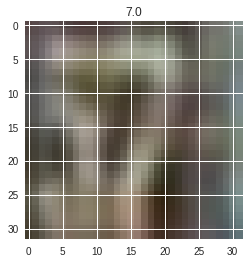

In [0]:
plt.imshow(X_train[600,:,:,:])
plt.title(Y_train[600,0])

In [0]:
def init_weights(in_features, out_features):
    W = np.random.randn(in_features, out_features) / sqrt(in_features)
    b = np.zeros(out_features)
    return W, b

In [0]:
class HiddenLinearLayer(object):
    def __init__(self, in_features, out_features, activation_fn):
        self.in_features = in_features
        self.out_features = out_features
        self.activation_fn = activation_fn
        
        W, b = init_weights(in_features, out_features)
        
        self.W = tf.Variable(W.astype(np.float32))
        self.b = tf.Variable(b.astype(np.float32))
        
        
    def forward(self, x):
        return self.activation_fn(tf.matmul(x, self.W) + self.b)
        

In [0]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

In [0]:
def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

In [0]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

In [0]:
def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [0]:
class CNN(object):
    def __init__(self, width, height, n_channels, n_classes):

        #self.input = tf.reshape(X, [-1, width, height, n_channels])
        self.X = tf.placeholder(tf.float32, shape=(None, width, height, n_channels), name='X')
        self.Y = tf.placeholder(tf.float32, shape=(None, n_classes), name='Y')
        self.keep_prob = tf.placeholder(tf.float32)
        self.set_pipeline()
        self.session = tf.InteractiveSession()
    
    def forward(self, X):
        
        conv_11 = tf.layers.conv2d(X, filters=32, kernel_size=[5,5], padding='SAME', activation=tf.nn.relu)
        drop_11 = tf.layers.dropout(conv_11, self.keep_prob)
        conv_12 = tf.layers.conv2d(conv_11, filters=64, kernel_size=[5,5], padding='SAME', activation=tf.nn.relu)
        pool_11 = tf.layers.max_pooling2d(conv_12, pool_size=[2,2], strides=2)

        conv_21 = tf.layers.conv2d(pool_11, filters=128, kernel_size=[5,5], padding='SAME', activation=tf.nn.relu)
        drop_21 = tf.layers.dropout(conv_21, self.keep_prob)
        conv_22 = tf.layers.conv2d(conv_21, filters=256, kernel_size=[5,5], padding='SAME', activation=tf.nn.relu)
        pool_21 = tf.layers.max_pooling2d(conv_22, pool_size=[2,2], strides=2)

        flat_3 = tf.layers.flatten(pool_21)

        fc_4 = tf.layers.dense(inputs=flat_3, units=1024, activation=tf.nn.relu)
        drop_5 = tf.layers.dropout(fc_4, self.keep_prob)
        fc_5 = tf.layers.dense(inputs=fc_4, units=10)
        return fc_5

    def set_pipeline(self):

        Y_pred = self.forward(self.X)
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.Y, logits=Y_pred))
        self.optimizer = tf.train.RMSPropOptimizer(learning_rate=0.0001, decay=0.95, momentum=0.9).minimize(self.cost)
        self.predictions = tf.argmax(Y_pred, axis=1)


    def fit(self, X, Y, MAX_ITER, n_batches, batch_size, print_time=None):

        Y_1hot = one_hot_encoder(Y).toarray().view(np.float32)
        
        init = tf.global_variables_initializer()
        self.session.run(init)
        for iter in range(MAX_ITER):
            X_shuffled, Y_1hot_shuffled, Y_shuffled = shuffle(X, Y_1hot, Y)
            for ibatch in range(n_batches):
                X_batch = X_shuffled[ibatch*batch_size:(ibatch+1)*batch_size,:]
                Y_1hot_batch = Y_1hot_shuffled[ibatch*batch_size:(ibatch+1)*batch_size,:]
                Y_batch = Y_shuffled[ibatch*batch_size:(ibatch+1)*batch_size,:]

                #print(X_batch.dtype, Y_batch.dtype)

                # Training
                train_cost = self.session.run(self.cost, feed_dict={self.X:X_batch, self.Y:Y_1hot_batch})
                self.session.run(self.optimizer, feed_dict={self.X:X_batch, self.Y:Y_1hot_batch, self.keep_prob:0.5})

                if print_time==None:
                    print_time = n_batches//2

                if ibatch%print_time == 0:
                    print('Epoch:{}, Batch:{}, Train loss:{}'.format(iter, ibatch, train_cost))


    def predict(self, X, Y, n_batches, batch_size):

        correct = 0
        test_cost = 0
        total = 0
        Y_1hot = one_hot_encoder(Y).toarray().view(np.float32)
        for ibatch in range(n_batches):
            X_batch = X[ibatch*batch_size:(ibatch+1)*batch_size,:]
            Y_1hot_batch = Y_1hot[ibatch*batch_size:(ibatch+1)*batch_size,:]
            Y_batch = Y[ibatch*batch_size:(ibatch+1)*batch_size,:]

            test_cost += self.session.run(self.cost, feed_dict={self.X:X_batch,
                                                           self.Y:Y_1hot_batch, 
                                                           self.keep_prob:1.0})

            test_predictions = np.expand_dims(self.session.run(self.predictions, feed_dict={self.X:X_batch}), 1)

            #Y_batch = Y_test[ibatch*batch_size:(ibatch+1)*batch_size,:]
            correct += np.sum(test_predictions==Y_batch)
            total += len(Y_batch)

        print('Test loss:{}, Accuracy:{}%'.format(test_cost/n_batches, np.round(correct*100/total, 2)))


In [0]:
# def CNN_fn(X, Y, width, height, n_channels):
#     #input_layer = tf.reshape(X, [-1, width, height, n_channels])
#     conv_11 = tf.layers.conv2d(X, filters=32, kernel_size=[5,5], padding='SAME', activation=tf.nn.relu)
#     conv_12 = tf.layers.conv2d(conv_11, filters=64, kernel_size=[5,5], padding='SAME', activation=tf.nn.relu)
#     pool_11 = tf.layers.max_pooling2d(conv_12, pool_size=[2,2], strides=2)

#     conv_21 = tf.layers.conv2d(pool_11, filters=128, kernel_size=[5,5], padding='SAME', activation=tf.nn.relu)
#     conv_22 = tf.layers.conv2d(conv_21, filters=256, kernel_size=[5,5], padding='SAME', activation=tf.nn.relu)
#     pool_21 = tf.layers.max_pooling2d(conv_22, pool_size=[2,2], strides=2)

#     flat_3 = tf.layers.flatten(pool_21)

#     fc_4 = tf.layers.dense(inputs=flat_3, units=1024, activation=tf.nn.relu)
#     drop_5 = tf.layers.dropout(fc_4, keep_prob)
#     fc_5 = tf.layers.dense(inputs=fc_4, units=10)
#     return fc_5

In [0]:
WIDTH = 32
HEIGHT = 32
N_CHANNELS = 3
N_CLASSES = 10
BATCH_SIZE = 64
MAX_ITER = 10
N_BATCHES = X_train.shape[0]//BATCH_SIZE
PRINT_TIME = N_BATCHES//2
TEST_N_BATCHES = X_test.shape[0]//BATCH_SIZE

In [0]:
ann = CNN(WIDTH, HEIGHT, N_CHANNELS, N_CLASSES)

In [0]:
ann.predict(X_test, Y_test, TEST_N_BATCHES, BATCH_SIZE)

The labels are: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Test loss:0.5225323887881387, Accuracy:86.08%


In [0]:
ann.fit(X_train, Y_train, MAX_ITER, N_BATCHES, BATCH_SIZE, PRINT_TIME)

The labels are: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Epoch:0, Batch:0, Train loss:8.01297378540039
Epoch:0, Batch:572, Train loss:0.4002181887626648
Epoch:1, Batch:0, Train loss:0.5656787157058716
Epoch:1, Batch:572, Train loss:0.5066723227500916
Epoch:2, Batch:0, Train loss:0.6961677074432373
Epoch:2, Batch:572, Train loss:0.7945755124092102
Epoch:3, Batch:0, Train loss:0.11558525264263153
Epoch:3, Batch:572, Train loss:0.32069578766822815
Epoch:4, Batch:0, Train loss:0.20392143726348877
Epoch:4, Batch:572, Train loss:0.5163002014160156
Epoch:5, Batch:0, Train loss:0.06527089327573776
Epoch:5, Batch:572, Train loss:0.20671255886554718
Epoch:6, Batch:0, Train loss:0.15308062732219696
Epoch:6, Batch:572, Train loss:0.2812252938747406
Epoch:7, Batch:0, Train loss:0.4021178185939789
Epoch:7, Batch:572, Train loss:0.19396422803401947
Epoch:8, Batch:0, Train loss:0.15870577096939087
Epoch:8, Batch:572, Train loss:0.36389750242233276
Epoch:9, Batch:0, Train loss:0.29483646154403687
Epoch:9, Batch